# Unsupervised Learning - Clustering C

### I. [Standarize the Data](#Scaled-Data)
### II.[Principal Component Analysis](#Principal-Components-Analysis-(PCA))
### III. [Optimal Number of K Clusters](#Elbow-Method-Optimal-Number-of-K-Clusters)
### IV. [K Means Model](#K-Means-Model)
### V. [Pair Plot](#Pair-Plot)
### VI. [Cluster Report](#Cluster-Report)
### VII. [Summary](#Summary)


The object of this clustering analysis is to see if any interesting relationships exist in the wildfire dataset. Unlike supervised learning, in unsupervised learning there is no target to predict but rather we look for cateogries from the structure in our data. This approach is often used in marketing research.

My methodology includes the following steps:
- Standardize the data
- Consolidate the features using principal component analysis
- Determine the optimal number of K clusters using the elbow method
- Instantiate a K Means model
- Observe the results with a scatter plot
- Evaluate the result with a cluster report

methodology: https://archive.is/5DVOX#selection-1449.0-3381.3

**This notebook has the purpose of trying three PCA features instead of two.** 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn import cluster
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.metrics import pairwise_distances
 
import time

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Import Data

In [3]:
df = pd.read_csv('../data/california.csv', low_memory=False)
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday


In [4]:
df['stat_cause_descr_code'] = df['stat_cause_descr'].map({'Miscellaneous':0,
                                                                'Equipment Use':1,
                                                                'Lightning':2,
                                                               'Arson': 3 ,
                                                               'Debris Burning':4, 
                                                               'Missing/Undefined': 5, 
                                                               'Campfire': 6, 
                                                               'Children': 7,
                                                               'Smoking':8, 
                                                               'Powerline':9, 
                                                               'Railroad':10, 
                                                               'Fireworks':11, 
                                                               'Structure':12
                                                              })

In [5]:
df.head(3)

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word,stat_cause_descr_code
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday,0
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday,2
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday,4


## Feature Selection

In [6]:
features = ['fire_year',
            'discovery_doy',
#             'discovery_day_of_week',
#             'discovery_month',
            'fire_size',
            'latitude',
            'longitude']

In [7]:
# Quick look at the coorelation. I won't manipulate the correlations for PCA.
df[features].iloc[:,1:].corr()

,discovery_doy,fire_size,latitude,longitude
discovery_doy,1.000000,0.009892,0.075918,-0.070220
fire_size,0.009892,1.000000,-0.003499,0.002813
latitude,0.075918,-0.003499,1.000000,-0.876954
longitude,-0.070220,0.002813,-0.876954,1.000000


In [8]:
X = df[features]

## Scaled Data

In [9]:
# Scaled X
ss = StandardScaler()
X_sc = ss.fit_transform(X)

## Principal Components Analysis (PCA)

PCA is a very popular technique for performing "dimensionality reduction" on your data.
Dimensionality reduction is the process of combining or collapsing your existing features (columns in X) into new features that not only retain the original information (or as much of it as we can) but also ideally reduce noise.

Intuitively, PCA transforms the coordinate system so that the axes become the most concise, informative descriptors of our data as a whole.

In [10]:
pca = PCA().fit(X_sc)

In [11]:
pca_df = pd.DataFrame(pca.transform(X_sc))
pca_df.head()
pca_features = [0, 1, 2]
pca_df[pca_features]

,0,1,2
0,-0.693339,1.993208,-0.234239
1,-0.365046,0.825668,-0.114126
2,-0.519213,0.637177,-0.090562
3,-0.183929,0.322448,-0.051307
4,-0.190355,0.322917,-0.051352
...,...,...,...
189545,-1.706196,0.622974,0.202741
189546,-0.472661,0.461879,0.226088
189547,-0.206376,2.078969,0.024596
189548,-0.489720,0.368256,0.238521


In [12]:
pca.explained_variance_ratio_

array([0.37792527, 0.21775383, 0.20033797, 0.17943343, 0.02454951])

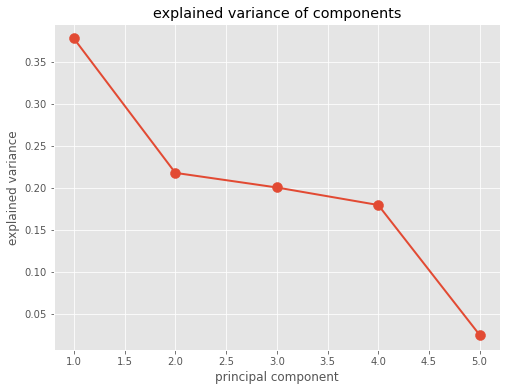

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,6), pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, 6), pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

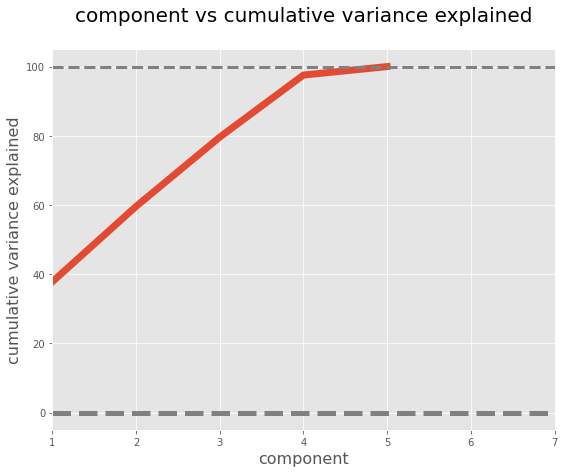

In [14]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100
plt.figure(figsize=(9,7))
component_number = range(1,6)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,7])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [15]:
pca1_evec = pca.components_[0]
for weight, event in zip(pca1_evec, df[features].iloc[:,1:].columns):
    print(event, weight)

discovery_doy -0.027128159536195625
fire_size -0.1125498555453523
latitude 0.0034791497624833616
longitude -0.7023562775281122


In [16]:
pca1_evec = pca.components_[1]
for weight, event in zip(pca1_evec, df[features].iloc[:,1:].columns):
    print(event, weight)

discovery_doy 0.7274501088229124
fire_size -0.6834912883881183
latitude -0.011104944532234285
longitude 0.03015980792138226


In [17]:
pca1_evec = pca.components_[2]
for weight, event in zip(pca1_evec, df[features].iloc[:,1:].columns):
    print(event, weight)

discovery_doy 0.09579409972652778
fire_size 0.08514370833172132
latitude 0.9917122365161327
longitude -0.0075587797660998605


## Elbow Method Optimal Number of K Clusters

In [18]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(pca_df[pca_features])
    kmeanModel.fit(X_sc)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
# code --> https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

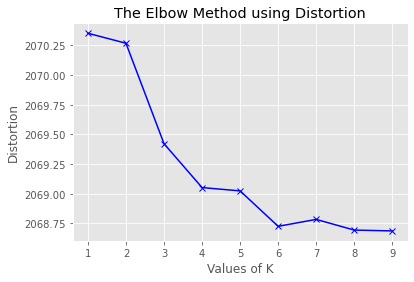

In [19]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [20]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 947750.0000000009
2 : 686954.964376407
3 : 586217.640613563
4 : 470063.58987601614
5 : 416178.44756471243
6 : 373797.3826595536
7 : 334650.09378577874
8 : 300153.7287767056
9 : 273383.3977578247


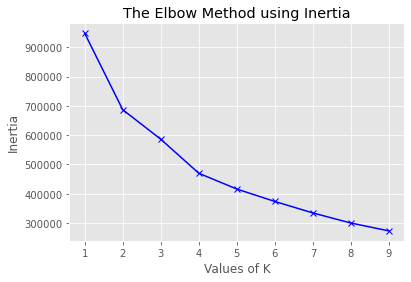

In [21]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## K Means Model

In [22]:
# 4 Clusters
k_mean = KMeans(n_clusters=4)
k_mean.fit(pca_df[pca_features])

labels = k_mean.labels_
clusters = k_mean.cluster_centers_

start_time = time.time()

print(silhouette_score(pca_df[pca_features], labels))

end_time = time.time()
print()
print('Took %s seconds to calculate.' % (end_time - start_time))


0.36579732467256565

Took 403.762531042099 seconds to calculate.


In [23]:
labels

array([2, 2, 2, ..., 2, 2, 1], dtype=int32)

## Pair Plot

<ipython-input-24-763a1aec59b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['clusters']=labels



Took 116.47976613044739 seconds to calculate.


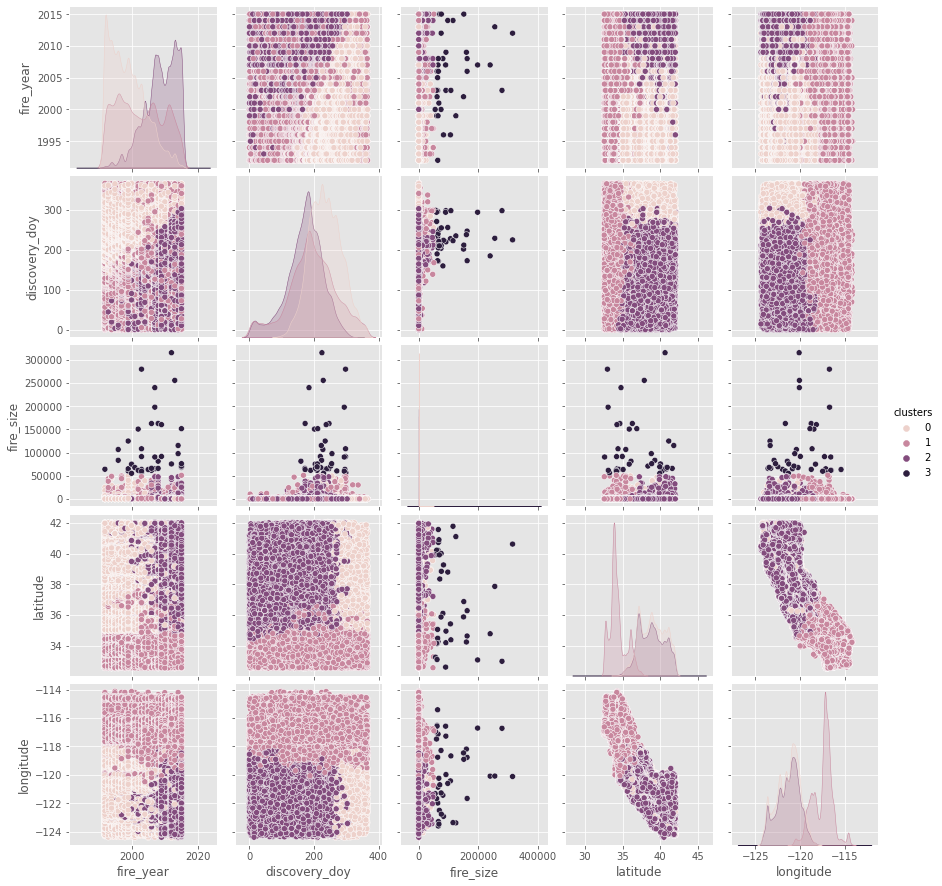

In [24]:
# visually examine the cluster that have been created
start_time = time.time()

X_2 = df[features]
X_2['clusters']=labels

sns.pairplot(data=X_2, hue='clusters')

end_time = time.time()
print()
print('Took %s seconds to calculate.' % (end_time - start_time))

## Cluster Report

In [25]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])
    
# code --> https://archive.is/5DVOX#selection-1449.0-3381.3

In [26]:
cluster_report(df[features], labels)

,class_name,instance_count,rule_list
0,0,70939,[0.6574637975368791] (longitude <= -119.31309509277344) and (fire_year <= 2003.5) and (discovery_doy <= 168.5) and (fire_year <= 1998.5)[0.9458752629484337] (longitude <= -119.31309509277344) and (fire_year <= 2003.5) and (discovery_doy > 168.5)[0.9288192501398993] (longitude <= -119.31309509277344) and (fire_year > 2003.5) and (discovery_doy > 237.5) and (fire_year <= 2009.5)[0.39677047289504036] (longitude > -119.31309509277344) and (latitude > 36.51077461242676)
2,1,58791,[0.9770714390279608] (longitude > -119.31309509277344) and (latitude <= 36.51077461242676)
1,2,59780,[0.841399607586658] (longitude <= -119.31309509277344) and (fire_year <= 2003.5) and (discovery_doy <= 168.5) and (fire_year > 1998.5)[0.9425999481910025] (longitude <= -119.31309509277344) and (fire_year > 2003.5) and (discovery_doy <= 237.5)[0.6420614518300893] (longitude <= -119.31309509277344) and (fire_year > 2003.5) and (discovery_doy > 237.5) and (fire_year > 2009.5)
3,3,40,NaN


## Summary

**Comparing the models:**

Out of the three unsupervised clustering model, Model C appears to be the best. As the table below shows, Model C has the highest silhouette score, uses the least number of clusters and captures 80% of the variance with 3 PCA features. These factors make for cleaner and easier to interpret clusters 

| Clustering Model Version | # of PCA Features | Variance Explained by PCA | # of K CLusters | Silhoutee Score |
|--------------------------|-------------------|---------------------------|-----------------|-----------------|
| A                        | 2                 | 60%                       | 6               | 0.358           |
| B                        | 0                 | n/a                       | 6               | 0.232           |
| C                        | 3                 | 80%                       | 4               | 0.366           |



**Interpreting Model C:**

The pair plot and cluster report are excellent resources that help us understand the clusters. The K means model created 4 clusters which were primarily categorized by location and time of fire. The scatter plot with latitude and longitude as the x and y axis shows a good visual of cluster 1 and 3. California is bisected by a line running roughly from Santa Barbara to Kings Canyon. Cluster 1 is located in the southern region and Cluster 3 is located in the northern region. The cluster report confirms this observation by detailing the rules of each cluster. The 58,838 fires in Cluster 1 are 100% categorized by their location. As a result, Cluster 1 includes old and new fires as shown in the "fire_year" and "latitude" plot. 

Cluster 0 is primarily defined by a westward longitude position and the day of discovery depending on the year. Fires before 2003 are more welcome into Cluster 3, which is composed of fires from May to December. However, fires between 2003 and 2009 are included only from September to December.

Like Cluster 1, Cluster 3 is also primarily defined by location but also adds nuances such as the year and discovery day. Cluster 3 can be thought as the other side of the coin to Cluster 0. As noted above, Cluster 0 included fires later in the year. Conversely, Cluster 1 includes the fires earlier in the year. The "discovery_doy" and "latitude" plot clearly shows this separation.

**Cluster Summary:**
- Cluster 0: These are fires before 2003 and discovered in the second half of their year. They are primarily located in the north and west parts of the state.
- Cluster 1: These fires are all located in southern California. Location is its only attribute.
- Cluster 2: This is a very small cluster of only 40 fires that did not fit with the other clusters. They represent the largest fires.
- Cluster 3: These are primarily fires located in northern California that were discovered earlier in the year.

| Clustering Model Version | # of PCA Features | Variance Explained by PCA | # of K CLusters | Silhoutee Score |
|--------------------------|-------------------|---------------------------|-----------------|-----------------|
| A                        | 2                 | 60%                       | 6               | 0.358           |
| B                        | 0                 | n/a                       | 6               | 0.232           |
| C                        | 3                 | 80%                       | 4               | 0.366           |

## Close up on select graphs

''

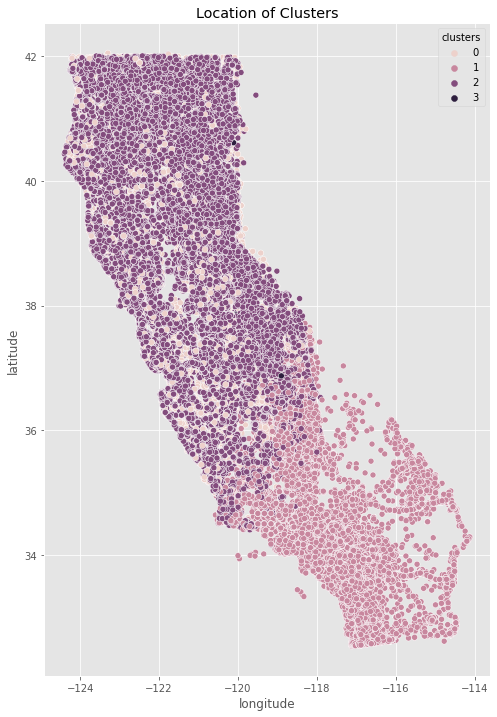

In [27]:
plt.figure(figsize=(8,12))
sns.scatterplot(data=X_2, x='longitude', y='latitude', hue='clusters')

plt.title('Location of Clusters')
;

The scatter plot above makes a shape of California. We can clearly see the geographic difference between Cluster 1 (southern California) and Cluster 3 (northern California).

''

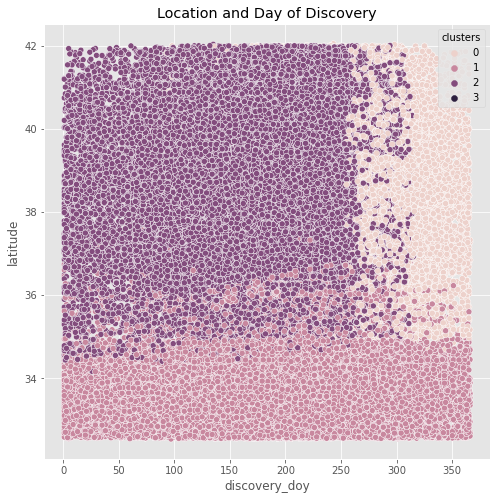

In [28]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=X_2, x='discovery_doy', y='latitude', hue='clusters')

plt.title('Location and Day of Discovery')
;

This scatter plot show the distinction between Cluster 0 and Cluster 3. These cluster are located in the same regions but occur in different times of the year. 

''

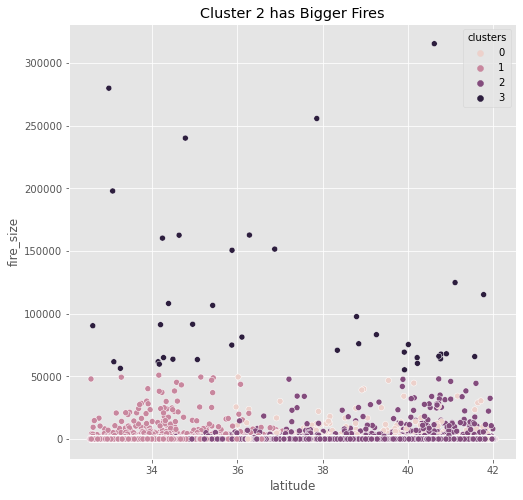

In [29]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=X_2, x='latitude', y='fire_size', hue='clusters')

plt.title('Cluster 2 has Bigger Fires')
;

Cluster 2 only has 40 fires and it's hard to find a pattern in the other scatter plot. This graph shows that Cluster 2 has the largest fires throughout the state. 


#### One more look at the location of each cluster

In [30]:
df['clusters'] = labels
# df.head(3)

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word,stat_cause_descr_code,clusters
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday,0,2
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday,2,2
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday,4,2


''

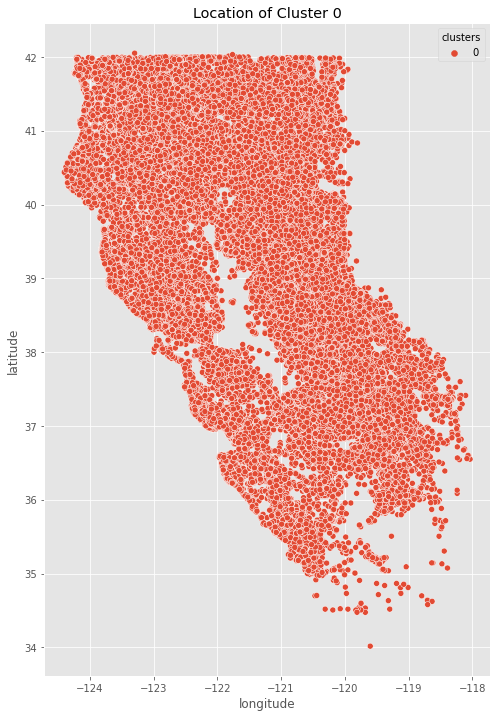

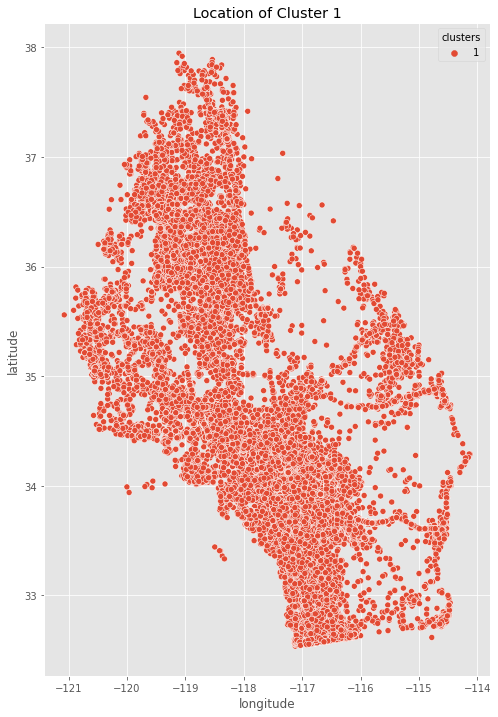

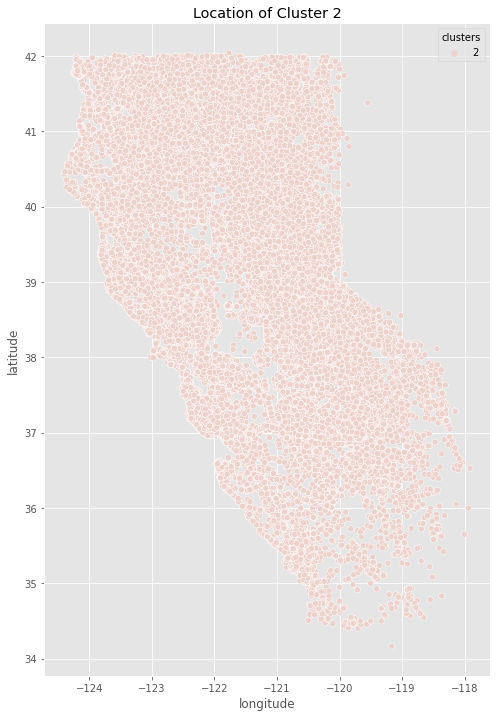

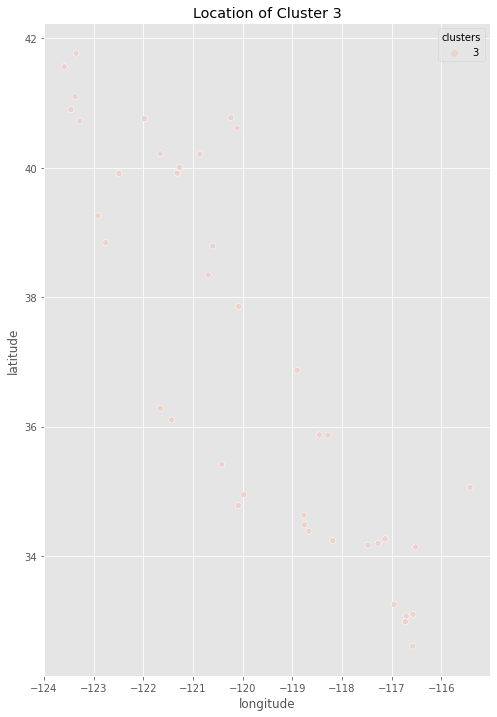

In [42]:
# Filters for each of the four clusters
cluster_0 = df[df['clusters'] == 0]
cluster_1 = df[df['clusters'] == 1]
cluster_2 = df[df['clusters'] == 2]
cluster_3 = df[df['clusters'] == 3]

# Plotting each cluster
plt.figure(figsize=(8,12))
# plt.subplot(2, 2, 1)
sns.scatterplot(data=cluster_0, x='longitude', y='latitude', hue='clusters')
plt.title('Location of Cluster 0')

plt.figure(figsize=(8,12))
# plt.subplot(2, 2, 2)
sns.scatterplot(data=cluster_1, x='longitude', y='latitude', hue='clusters')
plt.title('Location of Cluster 1')

plt.figure(figsize=(8,12))
# plt.subplot(2, 2, 3)
sns.scatterplot(data=cluster_2, x='longitude', y='latitude', hue='clusters')
plt.title('Location of Cluster 2')

plt.figure(figsize=(8,12))
# plt.subplot(2, 2, 4)
sns.scatterplot(data=cluster_3, x='longitude', y='latitude', hue='clusters')
plt.title('Location of Cluster 3')
;

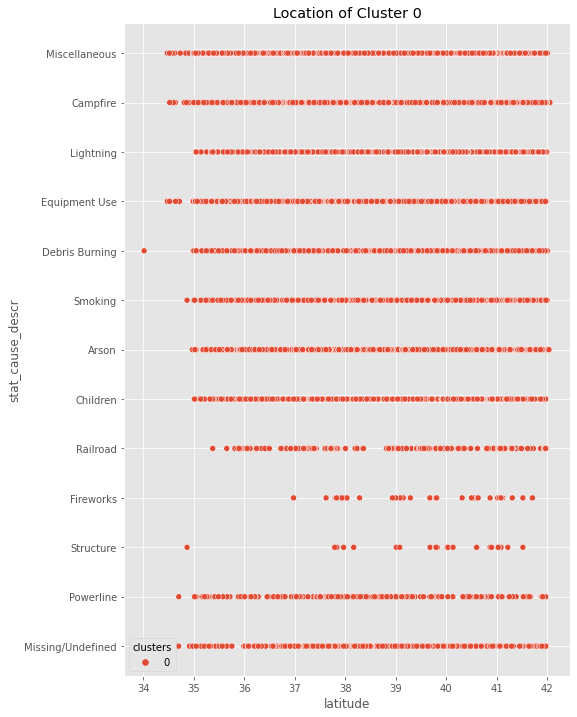

In [47]:
# Plotting each cluster
plt.figure(figsize=(8,12))
# plt.subplot(2, 2, 1)
sns.scatterplot(data=cluster_0, x='latitude', y='stat_cause_descr' , hue='clusters')
plt.title('Location of Cluster 0');

#### Barplots comparing the cause of the fire to the cluster

''

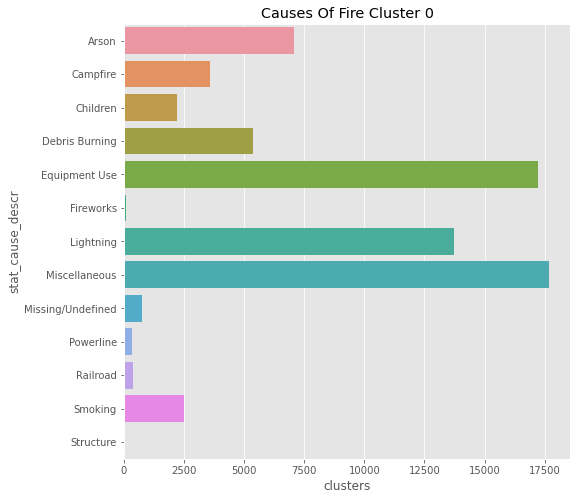

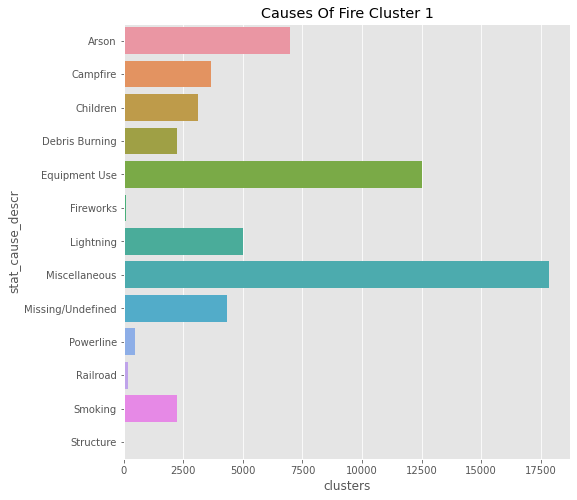

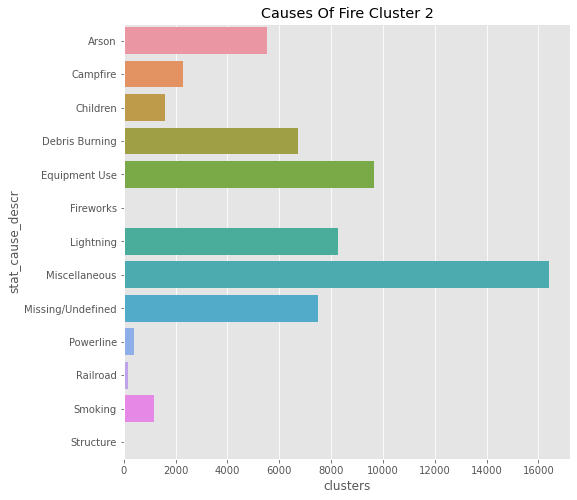

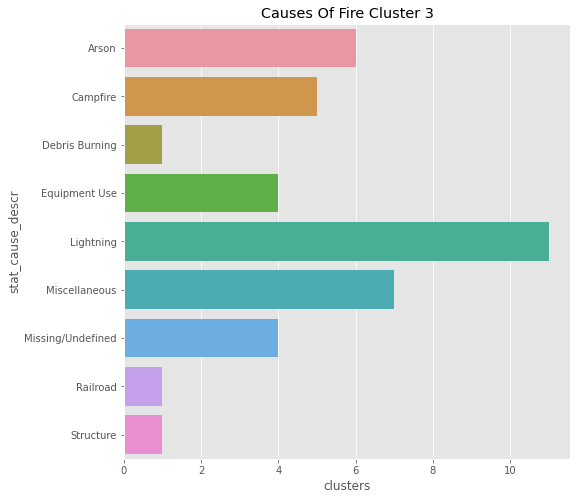

In [68]:
grouped_0 = cluster_0.groupby('stat_cause_descr')['clusters'].count().reset_index()
grouped_1 = cluster_1.groupby('stat_cause_descr')['clusters'].count().reset_index()
grouped_2 = cluster_2.groupby('stat_cause_descr')['clusters'].count().reset_index()
grouped_3 = cluster_3.groupby('stat_cause_descr')['clusters'].count().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(data=grouped_0, y='stat_cause_descr', x='clusters')
plt.title('Causes Of Fire Cluster 0')

plt.figure(figsize=(8,8))
sns.barplot(data=grouped_1, y='stat_cause_descr', x='clusters')
plt.title('Causes Of Fire Cluster 1')

plt.figure(figsize=(8,8))
sns.barplot(data=grouped_2, y='stat_cause_descr', x='clusters')
plt.title('Causes Of Fire Cluster 2')

plt.figure(figsize=(8,8))
sns.barplot(data=grouped_3, y='stat_cause_descr', x='clusters')
plt.title('Causes Of Fire Cluster 3')

;

#### Average Fire Size for Each Cluster

   clusters      fire_size
0         0      28.445391
1         1      58.354275
2         2      48.806230
3         3  109490.710500


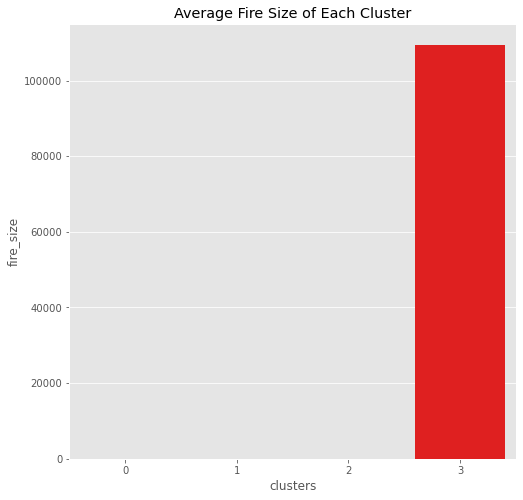

In [72]:
firesize = df.groupby('clusters')['fire_size'].mean().reset_index()
print(firesize)

plt.figure(figsize=(8,8))
sns.barplot(data=firesize, y='fire_size', x='clusters', color='red')
plt.title('Average Fire Size of Each Cluster');